In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time 

In [25]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('data.csv')

# Phân loại các bác sĩ và điều dưỡng
doctors1 = data[data['Position'] == 1].to_dict(orient='records')
doctors2 = data[data['Position'] == 2].to_dict(orient='records')
nurses = data[data['Position'] == 3].to_dict(orient='records')

# Tổng số ca trực cần xếp trong 2 tháng
total_shifts = 62

# Hàm mất mát
def loss_function(schedule, data, alpha1=1, alpha2=1, alpha3=1):
    n = len(data)
    m = total_shifts
    A = np.zeros(n)
    K = np.zeros(m)
    
    for i in range(m):
        doctors_in_shift = [schedule[i][0], schedule[i][1]]
        departments_in_shift = set()
        
        for doc_id in doctors_in_shift:
            departments_in_shift.add(data.iloc[doc_id - 1]["Department"])
        
        K[i] = len(departments_in_shift)
        
        for doc_id in doctors_in_shift:
            A[doc_id - 1] += 1
    
    mu_K = np.mean(K)
    mu_A = np.mean(A)
    
    term1 = alpha1 * np.sum((A - mu_A) ** 2)
    term2 = alpha2 * np.sum((4 - K) ** 2)
    
    points = data['Point']
    mu_dtnbs = np.mean(points[data['Position'] == 1])
    mu_dtnbsII = np.mean(points[data['Position'] == 2])
    mu_dtndd = np.mean(points[data['Position'] == 3])
    
    term3 = 0
    for i in range(m):
        points_in_shift = [points[schedule[i][j] - 1] for j in range(4)]
        mean_points_in_shift = np.mean(points_in_shift)
        term3 += (mean_points_in_shift - (mu_dtnbs + mu_dtnbsII + 2 * mu_dtndd) / 4) ** 2
    
    return term1 + term2 + alpha3 * term3

# Tối ưu hóa lịch làm việc
def optimize_schedule(data, total_shifts, iterations=10000):
    best_schedule = None
    best_loss = float('inf')
    losses = []
    iteration_counts = []
    
    start_time = time.time()  # Bắt đầu đếm thời gian

    for iteration in range(iterations):
        schedule = np.zeros((total_shifts, 4), dtype=int)
        
        for i in range(total_shifts):
            schedule[i][0] = random.choice(doctors1)["ID"]
            schedule[i][1] = random.choice(doctors2)["ID"]
            schedule[i][2] = random.choice(nurses)["ID"]
            schedule[i][3] = random.choice(nurses)["ID"]
        
        loss = loss_function(schedule, data)
        losses.append(loss)
        iteration_counts.append(iteration)
        
        if loss < best_loss:
            best_loss = loss
            best_schedule = schedule
    
    end_time = time.time()  # Kết thúc đếm thời gian
    elapsed_time = end_time - start_time  # Tính thời gian đã trôi qua

    # Tạo DataFrame cho các kết quả
    df_results = pd.DataFrame({
        'Iteration': iteration_counts,
        'Loss': losses
    })

    # Tạo DataFrame cho lịch làm việc tốt nhất
    best_schedule_df = pd.DataFrame(best_schedule, columns=['Doc1_ID', 'Doc2_ID', 'Nurse1_ID', 'Nurse2_ID'])
    best_schedule_df['Day'] = range(1, total_shifts + 1)

    # Thêm thông tin về tên, khoa và điểm thâm niên
    def get_info_by_id(id):
        info = data[data['ID'] == id].iloc[0]
        return info['Name'], info['Department'], info['Point']
    
    best_schedule_df[['Doc1_Name', 'Doc1_Department', 'Doc1_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Doc1_ID']), axis=1, result_type='expand')
    best_schedule_df[['Doc2_Name', 'Doc2_Department', 'Doc2_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Doc2_ID']), axis=1, result_type='expand')
    best_schedule_df[['Nurse1_Name', 'Nurse1_Department', 'Nurse1_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Nurse1_ID']), axis=1, result_type='expand')
    best_schedule_df[['Nurse2_Name', 'Nurse2_Department', 'Nurse2_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Nurse2_ID']), axis=1, result_type='expand')

    # Loại bỏ các cột ID
    best_schedule_df = best_schedule_df.drop(columns=['Doc1_ID', 'Doc2_ID', 'Nurse1_ID', 'Nurse2_ID'])

    return best_schedule_df, best_loss, df_results, elapsed_time

# Thực hiện tối ưu hóa và thu thập dữ liệu
best_schedule_df, best_loss, df_results, elapsed_time = optimize_schedule(data, total_shifts)


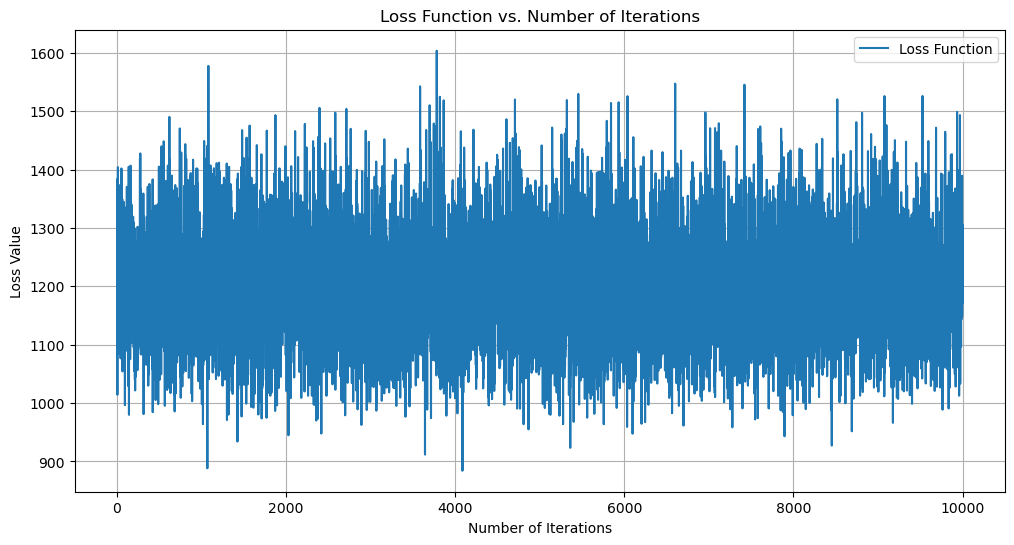

Best Loss: 884.0500000000001
Elapsed Time: 79.64 seconds


In [26]:
# Vẽ biểu đồ từ DataFrame và lưu vào file
plt.figure(figsize=(12, 6))
plt.plot(df_results['Iteration'], df_results['Loss'], label='Loss Function')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss Value')
plt.title('Loss Function vs. Number of Iterations')
plt.legend()
plt.grid(True)

# Lưu biểu đồ vào file ảnh
plt.savefig('loss_vs_iterations.png')

plt.show()

print(f"Best Loss: {best_loss}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

In [27]:
# Hiển thị DataFrame kết quả
best_schedule_df

,Day,Doc1_Name,Doc1_Department,Doc1_Point,Doc2_Name,Doc2_Department,Doc2_Point,Nurse1_Name,Nurse1_Department,Nurse1_Point,Nurse2_Name,Nurse2_Department,Nurse2_Point
0,1,Ngân Hà,External,10,Linh,Clinical,12,An,Internal,2,Văn Đức,External,19
1,2,Tâm,Emergency,17,Hà,Clinical,3,Quỳnh,Emergency,13,Hoài,External,9
2,3,Trang,External,15,Phượng,External,1,Quỳnh,Emergency,13,Long,Emergency,18
3,4,Xuân,Emergency,18,Giang,External,10,Huyền,Internal,20,Huệ,Internal,8
4,5,Bằng,Clinical,19,Giang,External,10,Hưng,Clinical,15,Thuận,Clinical,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,Ngân Hà,External,10,Hưng,Internal,4,Đông,Clinical,11,Thành,Clinical,22
58,59,Thanh Hà,External,6,Thuận,External,8,Ngân,Clinical,10,Quỳnh,Emergency,13
59,60,Hường,Internal,3,Thuận,External,8,Oanh,Emergency,11,Văn Đức,External,19
60,61,Bằng,Clinical,19,Minh Phương,Clinical,16,Thuận,External,15,Chí Đức,External,1
